In [176]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import os

plt.rcParams['figure.figsize'] = [20, 12]

### Metadatas

In [2]:
METADATA_PATH = 'data/project-1-at-2022-10-06-11-38-893ba3d4.json'
ANNOTAION_TO_FILENAME = {
    3: 'video_3.mp4',
    5: 'video_2.mp4',
    6: 'video_1.mp4',
}
VIDEO_FOLDER_PATH = 'videos/'
IMAGES_FOLDER_PATH = 'images/'

In [3]:
with open(METADATA_PATH) as f:
    data = json.load(f)

### Read in all of the keyframe sequence label metadatas

In [12]:
video_keyframe_sequences = dict()
frame_counts = dict()

for annotation in data:
    if annotation['id'] in ANNOTAION_TO_FILENAME:
        file_path = os.path.join(VIDEO_FOLDER_PATH, ANNOTAION_TO_FILENAME[annotation['id']])
        print(f'Processing "{file_path}"')
        
        labels = annotation['annotations'][0]['result']
        keyframe_sequences = list()
        
        for label_index, label in enumerate(labels):
            label_type = label['value']['labels'][0]
            frame_counts[annotation['id']] = label['value']['framesCount']
            
            sub_sequence = list()
            is_enabled = False
            
            for frame in label['value']['sequence']:
                frame['label_type'] = label_type
                frame['label_index'] = label_index
                
                if frame['frame'] > 0:
                    frame['frame'] = frame['frame'] - 1
                
                if frame['enabled'] == True:
                    is_enabled = True
                    sub_sequence.append(frame)
                elif frame['enabled'] == False and is_enabled:
                    sub_sequence.append(frame)
                    keyframe_sequences.append(sub_sequence)
                    sub_sequence = list()
            
            if len(sub_sequence) > 0:  
                keyframe_sequences.append(sub_sequence)
        
        video_keyframe_sequences[annotation['id']] = keyframe_sequences

Processing "videos/video_3.mp4"
Processing "videos/video_1.mp4"
Processing "videos/video_2.mp4"


In [79]:
FRAME_ID = 1205
ANNOTAION_ID = 3
KEYFRAME_SEQUENCE = 0

list(filter(lambda frame: frame['frame'] == FRAME_ID, video_keyframe_sequences[ANNOTAION_ID][KEYFRAME_SEQUENCE]))

[]

In [49]:
keyframe_sequences = video_keyframe_sequences[ANNOTAION_ID]
keyframe_sequences[0]

[{'x': 51.782363977485566,
  'y': 33.82322284761292,
  'width': 0.515947467167341,
  'height': 1.2507817385867825,
  'rotation': 0,
  'frame': 709,
  'enabled': True,
  'time': 23.7,
  'label_type': 'BAD_TRACK_PU_1_AND_2',
  'label_index': 0},
 {'x': 52.29831144465255,
  'y': 33.48968105065649,
  'width': 0.515947467167341,
  'height': 1.2507817385867825,
  'rotation': 0,
  'frame': 762,
  'enabled': True,
  'time': 25.466666666666665,
  'label_type': 'BAD_TRACK_PU_1_AND_2',
  'label_index': 0},
 {'x': 52.43316135084389,
  'y': 33.3854492391076,
  'width': 0.5452626641654743,
  'height': 1.292474463206344,
  'rotation': 0,
  'enabled': False,
  'frame': 775,
  'time': 25.9,
  'label_type': 'BAD_TRACK_PU_1_AND_2',
  'label_index': 0}]

In [141]:
frames = dict()

for i in range(frame_counts[ANNOTAION_ID]):
    labels = list()
    
    for keyframe_sequence in keyframe_sequences:
        first_frame = keyframe_sequence[0]
        last_frame = keyframe_sequence[-1]
        
        if first_frame['frame'] <= i and i <= last_frame['frame']:
            keyframe = list(filter(lambda frame: frame['frame'] == i, keyframe_sequence))
            if len(keyframe) > 0:
                frame = {
                    'label_type': keyframe[0]['label_type'],
                    'x': keyframe[0]['x'],
                    'y': keyframe[0]['y'],
                    'width': keyframe[0]['width'],
                    'height': keyframe[0]['height'],
                    'keyframe': True
                }
                
                labels.append(frame)
                continue
            
            keyframe_before = list(filter(lambda frame: frame['frame'] < i, keyframe_sequence))[-1]
            keyframe_after = list(filter(lambda frame: frame['frame'] > i, keyframe_sequence))[0]
            
            multiplier = (i - keyframe_before['frame']) / (keyframe_after['frame'] - keyframe_before['frame'])
            
            frame = {
                'label_type': keyframe_before['label_type'],
                'x': keyframe_before['x'] + (keyframe_after['x'] - keyframe_before['x']) * multiplier,
                'y': keyframe_before['y'] + (keyframe_after['y'] - keyframe_before['y']) * multiplier,
                'width': keyframe_before['width'] + (keyframe_after['width'] - keyframe_before['width']) * multiplier,
                'height': keyframe_before['height'] + (keyframe_after['height'] - keyframe_before['height']) * multiplier,
                'keyframe': False
            }
            
            labels.append(frame)
    
    if len(labels) > 0:
        frames[i] = labels
            

Processing "videos/video_3.mp4"
1080 1920


[ WARN:0@57599.865] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@57599.865] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin89 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@57599.867] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@57599.867] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/open

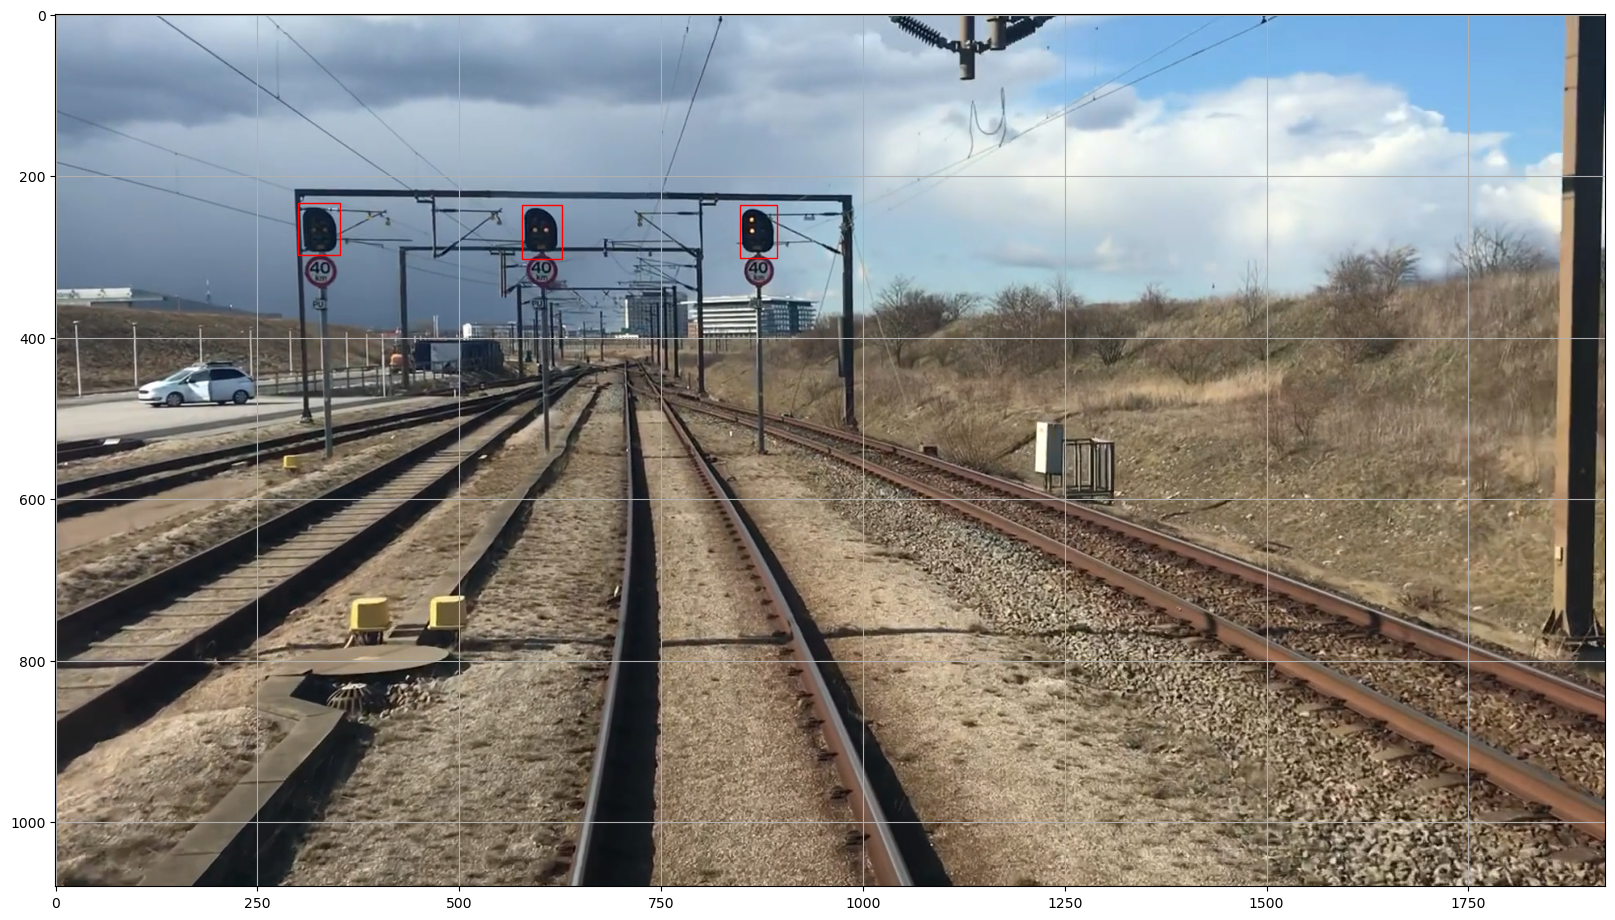

In [178]:
FRAME_ID = 2000

PADDING = 0.05

labels = frames[FRAME_ID]

file_path = os.path.join(VIDEO_FOLDER_PATH, ANNOTAION_TO_FILENAME[ANNOTAION_ID])
print(f'Processing "{file_path}"')

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, FRAME_ID+2)

ret, frame = cap.read()
(original_height, original_width, _) = np.array(frame).shape

print(original_height, original_width)

for i, label in enumerate(labels):
    pixel_x = int(label['x'] / 100.0 * original_width)
    pixel_y = int(label['y'] / 100.0 * original_height)
    pixel_width = int(label['width'] / 100.0 * original_width)
    pixel_height = int(label['height'] / 100.0 * original_height)
    
    pixel_x = pixel_x - int(pixel_width * PADDING)
    pixel_y = pixel_y - int(pixel_height * PADDING)
    pixel_width = pixel_width + int(pixel_width * PADDING * 2)
    pixel_height = pixel_height + int(pixel_height * PADDING * 2)
    
    crop_img = frame[pixel_y:pixel_y+pixel_height, pixel_x:pixel_x+pixel_width]
    cv2.imwrite(os.path.join('images_2', f'image_{i}.jpg'), crop_img)
    
    rect = patches.Rectangle((pixel_x, pixel_y), pixel_width, pixel_height, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.grid()

### Extract frame labels from keyframe sequences

In [6]:
video_fram_list = dict()

for annotation_id, keyframe_sequences in video_keyframe_sequences.items():
    file_path = os.path.join(VIDEO_FOLDER_PATH, ANNOTAION_TO_FILENAME[annotation_id])
    print(f'Processing "{file_path}"')
    
    frame_list = list()
    
    for keyframe_sequence in keyframe_sequences:
        for frame in keyframe_sequence:
            frame_list.append(frame['frame'])
    
    frame_list = list(sorted(set(frame_list)))
    print(f'Found {len(frame_list)} frames')
    
    video_fram_list[annotation_id] = frame_list

Processing "videos/video_3.mp4"
Found 196 frames
Processing "videos/video_1.mp4"
Found 120 frames
Processing "videos/video_2.mp4"
Found 153 frames


### Crop out all of the bounding boxes

In [7]:
MIN_SIZE = 40
PADDING = 0.05

for annotation_id, frame_list in video_frame_selection.items():
    file_path = os.path.join(VIDEO_FOLDER_PATH, ANNOTAION_TO_FILENAME[annotation_id])
    print(f'Processing "{file_path}"')
    
    keyframe_sequences = video_keyframe_sequences[annotation_id]
    
    cap = cv2.VideoCapture(file_path)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, frame = cap.read()
    (original_height, original_width, _) = np.array(frame).shape
        
    for frame_id in frame_list:
        keyframes = list()
    
        for keyframe_sequence in keyframe_sequences:
            for keyframe in keyframe_sequence:
                if keyframe['frame'] == frame_id:
                    keyframes.append(keyframe)
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        ret, frame = cap.read()
        
        if ret:
            for bounding_box in keyframes:            
                pixel_x = bounding_box['x'] / 100.0 * original_width
                pixel_y = bounding_box['y'] / 100.0 * original_height
                pixel_width = bounding_box['width'] / 100.0 * original_width
                pixel_height = bounding_box['height'] / 100.0 * original_height

                crop_img = frame[int(pixel_y-PADDING):int(pixel_y+pixel_height+PADDING), int(pixel_x-PADDING):int(pixel_x+pixel_width+PADDING)]
        
                if crop_img.shape[0] > MIN_SIZE and crop_img.shape[1] > MIN_SIZE:
                    image_path = os.path.join(IMAGES_FOLDER_PATH, f"{annotation_id}_{frame_id}_{bounding_box['label_index']}_{bounding_box['label_type']}_.jpg")
                    cv2.imwrite(image_path, crop_img)
        else:
            print(f'Error reading frame {frame_id}')
    
    cap.release()

Processing "videos/video_3.mp4"


[ WARN:0@42.201] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@42.201] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@42.201] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@42.201] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663

Processing "videos/video_1.mp4"


[ WARN:0@92.700] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@92.700] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin1 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@92.700] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@92.700] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663

Processing "videos/video_2.mp4"


[ WARN:0@97.884] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@97.884] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin2 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@97.885] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663872527491/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@97.885] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_c6qq9eqk9d/croots/recipe/opencv-suite_1663